In [1]:
using Pkg; for p in ("Knet","AutoGrad","Plots","Images","ImageMagick"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Knet
using Statistics
using Random
import Base: length, size, iterate, eltype, IteratorSize, IteratorEltype, haslength, @propagate_inbounds, repeat, rand, tail
import .Iterators: cycle, Cycle, take, repeat
using Plots; default(fmt=:png,ls=:auto)

┌ Info: Recompiling stale cache file /mnt/juliabox/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1190
┌ Warning: Package Plots does not have REPL in its dependencies:
│ - If you have Plots checked out for development and have
│   added REPL as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Plots
└ Loading REPL into Plots from project dependency, future warnings for Plots are suppressed.


In [8]:
# Load MNIST data from Knet
include(Knet.dir("data","mnist.jl"))
dtrn,dtst = mnistdata(xsize=(784,:), batchsize=100)

#uncomment if you have a gpu, you can check it via Knet.gpu()
#dtrn, dtst = mnistdata(xsize=(784,:), batchsize=100, xtype=Knet.KnetArray);

In [18]:
struct Chain
    layers
    Chain(layers...) = new(layers)
end


(c::Chain)(x) = (for layer in c.layers; x = layer(x); end; x)
(c::Chain)(x,y) = nll(c(x),y)
(c::Chain)(d::Knet.Data) = mean(c(x,y) for (x,y) in d)

In [22]:
function mytrain!(c::Chain, dtrn, dtst, valid=10, max_iters=500, )
    
    function pusher(c::Chain,dtrn,dtst,trnloss,tstloss)
        push!(trnloss, c(dtrn))
        push!(tstloss, c(dtst))
    end
    
    trnloss = []
    tstloss = []
    
    takeevery(n,itr) = (x for (i,x) in enumerate(itr) if i % n == 1)       
    #change the optimizer here: sgd, adam, ... @doc Knet.sgd to see other options :
    a = sgd(c, take(cycle(dtrn), max_iters+1))
    b = (pusher(c,dtrn,dtst,trnloss,tstloss) for x in takeevery(valid, a))
    progress!(b)    
    return 0:valid:max_iters, trnloss, tstloss
end

mytrain! (generic function with 3 methods)

In [23]:
function tgraph(c::Chain, dtrn, dtst, valid=10, max_iters=500)
    Training_Accuracy = accuracy(c, dtrn)
    Test_Accuracy = accuracy(c, dtst)
    println("Training Accuracy: ", accuracy(c, dtrn))
    println("Test Accuracy: ", accuracy(c, dtst))
    iters, trnloss, tstloss = mytrain!(c,dtrn,dtst,valid,max_iters)
    
    println("Training Accuracy: ", accuracy(c, dtrn))
    println("Test Accuracy: ", accuracy(c, dtst))
    plot(iters, [trnloss, tstloss], labels=[:trn, :tst], xlabel="iterations", ylabel="loss")
end

tgraph (generic function with 3 methods)

Multi Layer Perceptron

In [24]:
struct LinearLayer; w; b; f; end
LinearLayer(i::Int, o::Int, f=relu) = LinearLayer(param(o,i), param0(o),f)
(l::LinearLayer)(x) = l.f.(l.w * x .+ l.b);

Training Accuracy: 0.08495
Test Accuracy: 0.0847
┣      /       /       /       /       /       /       /   ┫ 121 [01:40, 1.21i/s]
Training Accuracy: 0.9251166666666667
Test Accuracy: 0.9241


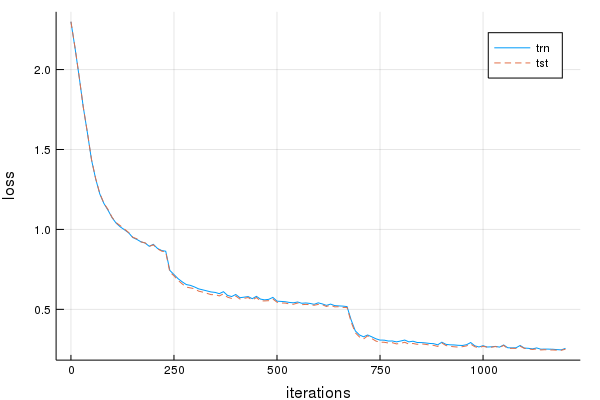

In [30]:
model = Chain(LinearLayer(784,64), LinearLayer(64,10))
tgraph(model, dtrn, dtst, 10, 1200)

Multi Layer Perceptron with Dropout

In [16]:
struct LinearLayerDropout; w; b; f; p; end
LinearLayerDropout(i::Int, o::Int; f=relu, p=0) = LinearLayerDropout(param(o,i), param0(o), f, p)
(l::LinearLayerDropout)(x) = l.f.(l.w * dropout(x, l.p) .+ l.b)    

Training Accuracy: 0.09258333333333334
Test Accuracy: 0.0902
┣       /       /       /       /       /       /       /  ┫ 121 [01:31, 1.33i/s]
Training Accuracy: 0.9145833333333333
Test Accuracy: 0.9223


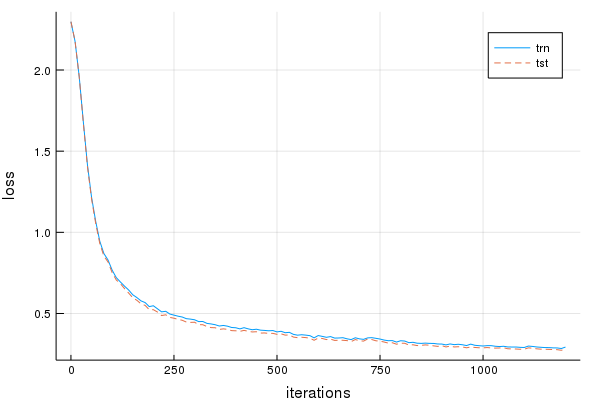

In [29]:
model_dropout = Chain(LinearLayerDropout(784,64;p=0.5), LinearLayerDropout(64,10;p=0.5))
tgraph(model_dropout, dtrn, dtst, 10, 1200)